In [1]:
#%pip install pykrx
#%pip install marcap_data
from marcap import marcap_data
from bs4 import BeautifulSoup
import requests
import re
import os 
import math
from pykrx import stock
from dateutil.relativedelta import relativedelta
import datetime
import pandas as pd
import numpy as np
import time
import itertools
import platform
from statsmodels.formula.api import ols

# 필요 데이터 불러오기 및 데이터 정제

## 코스피 개인 자금데이터를 불러옵니다. 코스피자금데이터는 KRX api를 통해 받아온 개인의 순매수 금액이므로 누적 매수합으로 표현해주었습니다.



In [2]:
# 누적 자금합으로 구해줍니다.

lasts=pd.read_excel("코스피 자금.xlsx")
lasts=lasts.set_index("날짜")["개인"]
lasts1=pd.DataFrame(list(itertools.accumulate(lasts)))
lasts1=lasts1.T
lasts1.columns=lasts.index

백테스팅 날짜 설정을 해줍니다. 2018년2월2일부터 2022년 2월전까지 백테스팅 할 예정입니다. 

In [3]:
#날짜가 4주 간격으로 제대로 나오는지 확인합니다.
input_date = datetime.datetime(2018, 2, 2)
date_list = [input_date+datetime.timedelta(weeks=4*i) for i in range(53)]
date_list

[datetime.datetime(2018, 2, 2, 0, 0),
 datetime.datetime(2018, 3, 2, 0, 0),
 datetime.datetime(2018, 3, 30, 0, 0),
 datetime.datetime(2018, 4, 27, 0, 0),
 datetime.datetime(2018, 5, 25, 0, 0),
 datetime.datetime(2018, 6, 22, 0, 0),
 datetime.datetime(2018, 7, 20, 0, 0),
 datetime.datetime(2018, 8, 17, 0, 0),
 datetime.datetime(2018, 9, 14, 0, 0),
 datetime.datetime(2018, 10, 12, 0, 0),
 datetime.datetime(2018, 11, 9, 0, 0),
 datetime.datetime(2018, 12, 7, 0, 0),
 datetime.datetime(2019, 1, 4, 0, 0),
 datetime.datetime(2019, 2, 1, 0, 0),
 datetime.datetime(2019, 3, 1, 0, 0),
 datetime.datetime(2019, 3, 29, 0, 0),
 datetime.datetime(2019, 4, 26, 0, 0),
 datetime.datetime(2019, 5, 24, 0, 0),
 datetime.datetime(2019, 6, 21, 0, 0),
 datetime.datetime(2019, 7, 19, 0, 0),
 datetime.datetime(2019, 8, 16, 0, 0),
 datetime.datetime(2019, 9, 13, 0, 0),
 datetime.datetime(2019, 10, 11, 0, 0),
 datetime.datetime(2019, 11, 8, 0, 0),
 datetime.datetime(2019, 12, 6, 0, 0),
 datetime.datetime(2020, 1, 

## 누적 자금 금액의 factor를 하는 과정입니다.

### 누적 자금금액을 변화량으로 나타낸 다음 한달 누적자금 평균이 리밸런싱 날짜에서의 누적금액보다 낮으면 상대적으로 누적 자금이 많아 개인의 영향력이 크다고 생각하였습니다.

In [4]:
#누적 자금금액의 변화량으로 데이터를 나타낸 다음 factor화

criteria_day = datetime.datetime(2018, 1, 5)

pct = lasts.transpose().pct_change().dropna().transpose() 
num=12 # num~newnum 까지의 거래대금 변화율의 평균을 가져오기 위해 설정해줍니다.
new_num=4 # num~현재까지의 거래대금 변화율의 평균을 가져오기 위해 설정해줍니다.

#기준일입니다.
criteria_day = criteria_day + datetime.timedelta(weeks = 1) 

mean_list=[]
for i in range(0,len(date_list)):
    end=criteria_day
    count_num=0
    
    # 만약 리밸런싱날짜의 거래자금 데이터가 휴장일이어서 없을경우 전날자의 거래대금을 가져오게끔 해주었습니다
    
    while end not in lasts.index:  
        count_num+=1
        end=criteria_day -datetime.timedelta(days=count_num)
    
    criteria_score1 = pct.transpose().loc[end - datetime.timedelta(weeks = num): end -datetime.timedelta(weeks = new_num)].mean()
    
    
   
    now_score1 = pct.transpose().loc[end - datetime.timedelta(weeks = new_num): end].mean()
    
    if criteria_score1<= now_score1 :# 현재값이 크면 1 작으면 0 입니다.
        mean_list.append(1)
    else:
        mean_list.append(0)
    
    criteria_day = criteria_day + datetime.timedelta(weeks = 1) #리밸런싱을 4주간격으로 해줍니다.



### factor를 trade_pd로 저장해줍니다.

In [5]:
trade_pd=pd.DataFrame(mean_list).T
trade_pd.columns=date_list[:]



<AxesSubplot:>

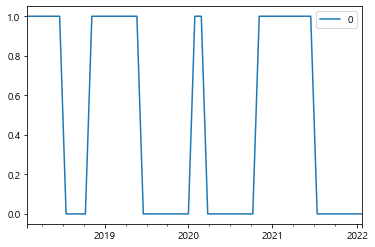

In [6]:
#어떻게 변화되는지 관찰합니다.

trade_pd.T.plot()

## 다음은 마켓 캡 데이터를 불러오는 함수입니다. 기간을 설정하여 불러올 수 있습니다.

 이후 시가총액 가중평균을 하는데 쓰일것입니다.


In [7]:
df_marcap = marcap_data('2018-01-02', '2022-02-04')


## 다음은 시기별 kospi universe 데이터를 불러와서 dataframe화 시키는 과정입니다. 

In [8]:
universe_data=pd.read_csv('kospi_universe.csv')

for index,i in enumerate(universe_data):
    code_list=[]
    for k in universe_data.loc[:,i]:
        try:
            if len(str(int(k))) != 6:
                code=( 6 - len(str(int(k))) )*"0" + str(int(k))
                code_list.append(code)

            else:
                code_list.append(str(int(k)))
        
        except:
            continue
        
    if index==0:
        #code_list=set(code_list)
        code_df=pd.DataFrame(code_list)
    else:
        
        code_df=pd.concat([code_df, pd.DataFrame(code_list) ],axis=1)
code_df.columns=universe_data.columns

In [9]:
code_df

,2018-02-02,2018-02-09,2018-02-16,2018-02-23,2018-03-02,2018-03-09,2018-03-16,2018-03-23,2018-03-30,2018-04-06,...,2021-10-29,2021-11-05,2021-11-12,2021-11-19,2021-11-26,2021-12-03,2021-12-10,2021-12-17,2021-12-24,2021-12-31
0,006840,006840,006840,006840,006840,006840,006840,006840,006840,006840,...,282330,282330,282330,282330,282330,282330,282330,282330,282330,282330
1,027410,027410,027410,027410,027410,027410,027410,027410,027410,027410,...,138930,138930,138930,138930,138930,138930,138930,138930,138930,138930
2,282330,282330,282330,282330,282330,282330,282330,282330,282330,282330,...,001040,001040,001040,001040,001040,001040,001040,001040,001040,001040
3,138930,138930,138930,138930,138930,138930,138930,138930,138930,138930,...,079160,079160,079160,079160,079160,079160,079160,079160,079160,079160
4,001040,001040,001040,001040,001040,001040,001040,001040,001040,001040,...,000120,000120,000120,000120,000120,000120,000120,000120,000120,000120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197,008770,008770,008770,008770,008770,008770,008770,008770,008770,008770,...,336260,336260,336260,336260,336260,006040,178920,178920,178920,178920
198,004800,004800,004800,004800,004800,004800,004800,004800,004800,004800,...,019170,019170,019170,019170,019170,001440,138040,138040,138040,138040
199,093370,093370,093370,093370,093370,093370,093370,093370,093370,093370,...,352820,352820,352820,352820,352820,323410,009900,009900,009900,009900
200,069260,069260,069260,069260,069260,069260,069260,069260,069260,069260,...,375500,375500,375500,375500,375500,259960,005850,005850,005850,005850


## 다음은 벤치마크 데이터인 코덱스200 가격데이터를 KRX를 통해서 가져오는 코드입니다.

### 휴장일일 경우에는 전날의 값을 채우도록 하였습니다.

In [10]:
#코덱스 200
df_bench = stock.get_etf_ohlcv_by_date(datetime.datetime(2018, 2, 2),date_list[-1]+datetime.timedelta(weeks=4), "069500", 'd')
df_bench=df_bench.asfreq('D').fillna(method='ffill')

In [11]:
#블룸버그에서 가져온 가격데이터입니다. 휴장일의 경우 ffill로 앞의 종가를 채워넣었습니다.

price_data=pd.read_excel("korea_price.xlsx")
price_data=price_data.set_index("ID").T.asfreq('D').fillna(method='ffill').T

### 한국 시장이 열릴때만 가져오기 위해서 KRX데이터 중 코스피데이터가 있는 날짜만 가져온 코드입니다.

차후에 데이터를 가져올때 주가데이터가 없음을 방지하기위해 all_idx를 통해 검사하며 휴장일일경우 날짜를 조정해줄 것입니다

In [13]:
all_idx=stock.get_etf_ohlcv_by_date(datetime.datetime(2018, 2, 2),datetime.datetime(2022, 2, 18), "069500", 'd').index

<p style="font-size:20px"> 저장공간을 덜어내기 위해 해당 유니버스인 주식만 불러옵니다</p>

In [14]:
df_marcap=df_marcap[df_marcap.Market=="KOSPI"]

## 마켓 regime 데이터를 불러오는 과정입니다.

<p style="font-size:20px"> 파일 설명 : 불황일경우 regime이 높아집니다.</p>

### 변화량을 구한뒤 변화량에 따라 호황 불황을 나누어줍니다.

In [15]:
regime_list=pd.read_csv("4regimes.csv").regime[1:].reset_index(drop=True)-pd.read_csv("4regimes.csv").regime[:-1].reset_index(drop=True)
regime_pd=pd.DataFrame(regime_list).T
regime_pd.columns=pd.read_csv("4regimes.csv").Date.iloc[1:]
last_regime_list=[]
change_value=0
for i in regime_pd.values[0]:
    
    if i !=0:
        change_value=i

    if change_value >0:
        last_regime_list.append(0) #불황
    elif change_value <0:
        last_regime_list.append(1) #호황
    else:
        last_regime_list.append(1)

            
            

In [16]:
last_regime=pd.DataFrame(last_regime_list).T
last_regime.columns=pd.read_csv("4regimes.csv").Date.iloc[1:]


#  게시글파일을 하나씩 불러와 점수 계산을 해주는 코드입니다.

## 백테스트의 시간을 줄이기 위해서 미리 계산한 점수를 csv파일로 저장해줍니다.

처음 계산시 switch = on으로 설정해두시고 이후에는 기간이 같으면 점수는 고정되므로 switch=off로 두시면 됩니다.


In [ ]:
switch="on"

#for문을 통해 점차 시간이 지납니다.
criteria_day = datetime.datetime(2018, 2, 2) #금요일 / 시작날짜인 동시에 4주 뒤에 종가로 파는 매도날짜입니다.

rebalance_day = criteria_day+datetime.timedelta(3) #월요일 / 매수날짜입니다. for문을 통해 점차 시간이 지납니다.

# 해당 유니버스를 집어넣습니다.
universe1=code_df

stock_search_list=[]

day_buy_list = []

return_list = []

rebalance_date = []

date_list_week=[]

change_col_list=[]


k_num=0
out=0

for i in range(0,len(date_list)):
    buy_list=[]
    
    try:
        # 파일의 길이가 넘어가면 자동으로 종료됩니다.
        if out==1:
            break
        
        if 4*i>= len(universe1):
            print('out')
            buy_list=universe1.iloc[:,-1].tolist()
            out=1
        else:
            buy_list=universe1.iloc[:,4*i].tolist()
    except:
        break
    
    day=criteria_day
    k_list=[]# 스코어 담을거
    print(day)
    
    buy_list=[i for i in buy_list if (i!="") ]
    buy_list=[x for x in buy_list if pd.isnull(x) == False]
    #print(len(buy_list))
    k_num+=1
    if switch=="on":
        for code in buy_list:

            #파일명은 직접 바꿔주셔야합니다. 제가 저장한 게시물엑셀파일이름은 코드명+날짜였습니다.
            file1='C:/wonsik/stock_kospi_all_csv/' + code + "2021-12-31.csv"
            search_keyword=""
            
            if os.path.isfile(file1) ==True:
                
                data=pd.read_csv(file1)
                

                


            else:
                print(code)
                data=pd.DataFrame(pd.read_csv('C:/wonsik/stock_kospi_all_csv/' + code + "2021-12-311.txt"))
                

            #continue
            data["날짜"]=pd.to_datetime(data['날짜'], format="%Y-%m-%d")

            data['score']= (data["공감"]+data["비공감"])/data["조회"]
            data=data.fillna(0)
            

            days= day-datetime.timedelta(weeks=4)
           
            k_list.append( data[ (data["날짜"]<=day) & (data["날짜"]>=days) ]["score"].mean())
            

        if k_num==1:
            k_df=pd.DataFrame(k_list)
        else:
            k_df=pd.concat([k_df,pd.DataFrame(k_list)],axis=1)
        
        
        #print(df_buy)
    criteria_day = criteria_day + datetime.timedelta(weeks=4)
    rebalance_day = rebalance_day + datetime.timedelta(weeks=4)
    
    

### 밑의 코드는 저장이 안되있을경우 저장을 해줘서 이후 백테스트를 하는데 시간을 단축시킬 수 있습니다.

In [ ]:
'''
k_df.columns=date_list[:-1]
k_df
k_df.to_excel("k_df.xlsx")
'''

# 백테스트 코드

## 이제부터는 전략에 따라 따로 실행을 해주셔야합니다. 전략은 총 3개가 있습니다.

1. long_only
국면에 따라 상위 혹은 하위 스코어의 주식을 long하는 전략을 취합니다.
2. long_short
국면에 따라 팩터의 분위에 맞게 long-short 전략을 취합니다.
3.long_hedge
long-short 에서 short position 대신에 inverse ETF를 매수하는 전략을 취합니다.

## 한개의 for문으로 이루어져있습니다. 날짜가 첫 for문이며 이후 종목을 스코어로 거른 뒤 해당 종목들을 for문으로 수익률 데이터와 가중치 데이터를 구해줘서 최종 포트폴리오의 수익률을 구해줍니다.

## 포트폴리오는 월간 리밸런싱 되며, 주간 수익률을 찍어주기 위해서 week_num을 추가해줘 금요일 종가 -> 다음주 금요일 종가까지의 수익률을 찍어주면서 기록을 하게끔 하였습니다.

In [177]:

#최종 long-only 백테스팅 코드
name="long_only"

criteria_day = datetime.datetime(2018, 2, 2) #금요일
rebalance_day = criteria_day+datetime.timedelta(3) #월요일

stock_search_list=[]
universe1=code_df
day_buy_list = []
return_list = []
rebalance_date = []
date_list_week=[]
change_col_list=[]

date_list_month=[]

regime_high_list = []
regime_high_stock_list=[]

regime_low_stock_list=[]

regime_low_list = []
low_day=[]
high_day=[]
high_value=pd.DataFrame()
low_value=pd.DataFrame()



k_num=0
out=0
for i in range(0,len(date_list)):
    buy_list=[]

    
    if out==1:
        break

    before_num=0
    before_days=criteria_day
    while str(before_days)[:10] not in universe1.columns:
        before_num+=1
        before_days=criteria_day+datetime.timedelta(days=before_num)
    
    
    
    
    if 4*i>= len(universe1):
        print('out')
        buy_list=universe1.iloc[:,-1].tolist()
        out=1
    else:
        buy_list=universe1.loc[:,str(before_days)[:10]].tolist()
    
    
    k_list=[]# 스코어 담을거
    
    
    buy_list=[i for i in buy_list if (i!="") ]
    buy_list=[x for x in buy_list if pd.isnull(x) == False]
    
    k_num+=1
    # 미리 저장해두었던 게시글 관심도 score 데이터 프레임을 불러옵니다.
    df_buy=pd.read_excel("k_df_score.xlsx",index_col = 0)
    
    df_buy=df_buy.iloc[:len(buy_list),i]
    df_buy=pd.concat([pd.DataFrame(buy_list),df_buy],axis=1)
    df_buy.columns=["Ticker","score"]
    df_buy=df_buy.fillna(0)
    
    df_buy=df_buy[df_buy.score!=0]
    
  ################# 국면 계산 #########


        
    print("국면계산")
    
    regime_data=last_regime.T.reset_index()
    regime_data.columns=["Date",'regime']
    now_index=regime_data[regime_data.Date==str(rebalance_day)[:10]].index
    
    last_four_regime=regime_data.regime.iloc[int(now_index[0])-1:int(now_index[0])].mean()
    
    print(last_four_regime)
    
    trade_now=int(trade_pd.T.iloc[i])
    print(trade_now)
        
    
    
    trade_now=int(trade_pd.T.loc[criteria_day])
    
####################################################################
    
    re_score=0 # 이후 해당 국면에 대해 데이터를 저장하기 위해 추가해주었습니다
    stock_nums=20 #주식 매수 비중 상위 n 개
    
    if last_four_regime ==1 and trade_now==0:
        bench_on=0 
        print("호황기")
        buy_list=df_buy.set_index("Ticker").sort_values(by="score",ascending=True)[:stock_nums].index
        print(buy_list)
        re_score=2 # 이후 해당 국면에 대해 데이터를 저장하기 위해 추가해주었습니다
        
    elif last_four_regime ==0 and trade_now==1 :
        bench_on=0
        print("불황기")
        re_score=1 # 이후 해당 국면에 대해 데이터를 저장하기 위해 추가해주었습니다
        buy_list=df_buy.set_index("Ticker").sort_values(by="score",ascending=False)[:stock_nums].index #상위
        
        


    
    else:
        print("관심없음")
        bench_on=1 # bench=on일 경우 kodex200 데이터로 수익률을 구해옵니다.
        
    
    
    
        
######################################################################

    
    
    
    
    
    
    rebalance_day2=rebalance_day
    print(rebalance_day)
    
    # 시가총액을 구하기위해서 df_marcap 데이터 프레임에서 날짜에 맞는 데이털르 불러옵니다.
    #없을시 가까울 시일내의 값들을 불러오게끔 하였습니다.
    try:
        mkt_data=df_marcap.loc[rebalance_day,['Marcap','Code']].set_index("Code")
    except:
        before_days=0
        before_num=0
        while before_days not in df_marcap.index:
            before_num+=1
            before_days=rebalance_day-datetime.timedelta(days=before_num)
        mkt_data=df_marcap.loc[before_days,['Marcap','Code']].set_index("Code")
    
    
        
    buy_list = [i for i in buy_list if i in mkt_data.index]
    
    
    # buy_list에 있는 모든 종목의 시가총액의 합을 구합니다.
    total_mkt=mkt_data.loc[buy_list].sum()
    
    
    date_list_month.append(rebalance_day2)
    
    ticker_list=[]
    weight_list=[]
    
    for weeks_num in range(0,4):
        
        
        tmpt_list = []
        
        
        df = price_data
        
        count_num=0
        start=rebalance_day2
       
            
        
        
        if weeks_num==0:
            
            if re_score==2: # 호황기 스코어가 높은 종목의 코드정보를 담습니다.
                high_day.append(rebalance_day2)
                if high_value.empty:
                    high_value=pd.DataFrame(buy_list)
                    
                else:
                    high_value=pd.concat([high_value,pd.DataFrame(buy_list)],axis=1,ignore_index=True)
                    

        
            if re_score==1: # 불황기 스코어가 높은 종목의 코드정보를 담습니다.
                low_day.append(rebalance_day2)
                if low_value.empty:
                    low_value=pd.DataFrame(buy_list)
                    
                else:
                    low_value=pd.concat([low_value,pd.DataFrame(buy_list)],axis=1,ignore_index=True)
                    
            
            
            
            
            end_day2=rebalance_day2+datetime.timedelta(days=4)
            
        else:
            end_day2=rebalance_day2+datetime.timedelta(weeks=1)
            
        
        print(rebalance_day2,end_day2) 
        #날짜입니다. 주가 넘어갈때마다 날짜가 1주씩 바뀌는지 확인해줍니다.
        
        
    

        
        
        if weeks_num == 0:
            #첫 주의 경우는 월요일 시가에서 금요일 종가의 수익률을 구해줘야하므로 
            #코드가 약간 다릅니다.
            
            #의미없는 국면일시 benchmark 데이터로 수익률을 구하는 과정입니다.
            if bench_on==1:
                
                try:
                    buy_p=df_bench.loc[rebalance_day2,"시가"]

                    sell_p=df_bench.loc[end_day2,"종가"]
                
                except:
                     
                    sell_p=df_bench.loc[end_day2-datetime.timedelta(days = 1),"종가"]
               
                return_list.append((sell_p/buy_p)-1 )
                rebalance_day2 =criteria_day + datetime.timedelta(weeks = 1)
                date_list_week.append(rebalance_day2)
                continue
            
            
            
            
            
            
            
            for ticker in buy_list:
                
                market_cap=mkt_data.loc[ticker]
                
                buy_p=df.loc[ticker+" KS Equity",start]
                sell_p=df.loc[ticker+" KS Equity",end_day2]
                tmpt_list.append((sell_p/buy_p-1) * float( market_cap/total_mkt)  )
                
                
                weight_list.append( float( market_cap/total_mkt)  ) 
                if sell_p/buy_p-1 ==0 :
                    print(ticker, 0)

                
                
            tmpt_list = [x for x in tmpt_list if math.isnan(x) == False]
            return_list.append(sum(tmpt_list))
            rebalance_day2 =criteria_day + datetime.timedelta(weeks = 1)
            date_list_week.append(rebalance_day2)
            
            one_week_close_p=df.loc[:,end_day2]
            
            
        else:
            # 첫주를 제외한 나머지 주
            if bench_on==1:
                
                try:
                    buy_p=df_bench.loc[rebalance_day2,"종가"]

                    sell_p=df_bench.loc[end_day2,"종가"]
                
                except:
            
                    sell_p=df_bench.loc[end_day2-datetime.timedelta(days = 1),"종가"]
                
                return_list.append((sell_p/buy_p)-1 )
                rebalance_day2 =criteria_day + datetime.timedelta(weeks = weeks_num+1)
                date_list_week.append(rebalance_day2)
                continue
                
            
            
            
            
            
            for ticker in buy_list:
                market_cap=mkt_data.loc[ticker]
                
                buy_p=df.loc[ticker+" KS Equity",start]
                sell_p=df.loc[ticker+" KS Equity",end_day2]
                
                tmpt_list.append((sell_p/buy_p-1) * float( market_cap/total_mkt)  )
                
                
                
            
            tmpt_list = [x for x in tmpt_list if math.isnan(x) == False] #오류값은 빼줍니다.
            return_list.append(sum(tmpt_list)) #최종 수익률 구하는과정
            rebalance_day2 =criteria_day + datetime.timedelta(weeks = weeks_num+1)
            date_list_week.append(rebalance_day2) #주간수익률이 찍히는 날짜를 리스트에 넣습니다.
            
            
    criteria_day = criteria_day + datetime.timedelta(weeks=4)
    rebalance_day = rebalance_day + datetime.timedelta(weeks=4)


국면계산
0.0
1
불황기
2018-02-05 00:00:00
2018-02-05 00:00:00 2018-02-09 00:00:00
2018-02-09 00:00:00 2018-02-16 00:00:00
2018-02-16 00:00:00 2018-02-23 00:00:00
2018-02-23 00:00:00 2018-03-02 00:00:00
국면계산
0.0
1
불황기
2018-03-05 00:00:00
2018-03-05 00:00:00 2018-03-09 00:00:00
030200 0
2018-03-09 00:00:00 2018-03-16 00:00:00
2018-03-16 00:00:00 2018-03-23 00:00:00
2018-03-23 00:00:00 2018-03-30 00:00:00
국면계산
0.0
1
불황기
2018-04-02 00:00:00
2018-04-02 00:00:00 2018-04-06 00:00:00
033780 0
001680 0
2018-04-06 00:00:00 2018-04-13 00:00:00
2018-04-13 00:00:00 2018-04-20 00:00:00
2018-04-20 00:00:00 2018-04-27 00:00:00
국면계산
1.0
1
관심없음
2018-04-30 00:00:00
2018-04-30 00:00:00 2018-05-04 00:00:00
2018-05-04 00:00:00 2018-05-11 00:00:00
2018-05-11 00:00:00 2018-05-18 00:00:00
2018-05-18 00:00:00 2018-05-25 00:00:00
국면계산
1.0
1
관심없음
2018-05-28 00:00:00
2018-05-28 00:00:00 2018-06-01 00:00:00
2018-06-01 00:00:00 2018-06-08 00:00:00
2018-06-08 00:00:00 2018-06-15 00:00:00
2018-06-15 00:00:00 2018-06-22 00:00

국면계산
0.0
0
관심없음
2020-06-22 00:00:00
2020-06-22 00:00:00 2020-06-26 00:00:00
2020-06-26 00:00:00 2020-07-03 00:00:00
2020-07-03 00:00:00 2020-07-10 00:00:00
2020-07-10 00:00:00 2020-07-17 00:00:00
국면계산
1.0
0
호황기
Index(['000660', '064960', '028050', '020150', '000270', '002960', '018880',
       '011170', '015760', '002240', '192400', '003240', '014830', '012750',
       '010120', '138930', '005380', '005610', '019680', '014680'],
      dtype='object', name='Ticker')
2020-07-20 00:00:00
2020-07-20 00:00:00 2020-07-24 00:00:00
002960 0
2020-07-24 00:00:00 2020-07-31 00:00:00
2020-07-31 00:00:00 2020-08-07 00:00:00
2020-08-07 00:00:00 2020-08-14 00:00:00
국면계산
1.0
0
호황기
Index(['192400', '019680', '000660', '014830', '014680', '028050', '005380',
       '000670', '064960', '005610', '051910', '010060', '011170', '002960',
       '020150', '000270', '060980', '004490', '002240', '018880'],
      dtype='object', name='Ticker')
2020-08-17 00:00:00
2020-08-17 00:00:00 2020-08-21 00:00:00
064960 

### 다음 코드는 long_short 수익류를 구하는 코드입니다. 위와 거의 동일하며 buy_list데이터말고 short_list를 국면을 판단할때 같이 생성됩니다.

### 주의: 만일 롱온리 코드 결과를 보고싶을 시, 코드를 돌리지말고 밑의 데이터 분석 결과 코드로 넘어가시길 바랍니다! 코드가 겹칩니다.

In [211]:

#롱숏임을 확인하는 코드입니다.
name="long_hedge"
long_short=True
#long_short -> 거의 위의 코드가 동일합니다.

criteria_day = datetime.datetime(2018, 2, 2) #금요일
rebalance_day = criteria_day+datetime.timedelta(3) #월요일
stock_search_list=[]
universe1=code_df
day_buy_list = []
return_list = []
rebalance_date = []
date_list_week=[]
date_list_month=[]
change_col_list=[]


out=0


regime_high_list = []
regime_high_stock_list=[]

regime_low_stock_list=[]

regime_low_list = []
low_day=[]
high_day=[]
high_value=pd.DataFrame()
low_value=pd.DataFrame()


for i in range(0,len(date_list)):
    buy_list=[]
    try:
        if out==1:
            break
        
        if 4*i>= len(universe1):
            buy_list=universe1.iloc[:,-1].tolist()
            out=1
        else:
            buy_list=universe1.iloc[:,4*i]
    
    except:
        break
    
    #day=datetime.datetime.strptime(universe1.columns[i],"%Y-%m-%d")
    k_list=[]# 스코어 담을거
    
    


    df_buy=pd.read_excel("k_df_score.xlsx",index_col = 0)
    
    df_buy=df_buy.iloc[:len(buy_list),i]#.dropna()
    df_buy=pd.concat([pd.DataFrame(buy_list),df_buy],axis=1)
    df_buy.columns=["Ticker","score"]
    df_buy=df_buy.fillna(0)
    df_buy=df_buy[df_buy["score"]!=0]
        
######################## 국면 계산 #######################################
# 위와 다른 점은 이부분입니다. 국면마다 short 리스트가 추가되면 long과 정 반대 스코어가 들어값니다.
    print("국면계산")
    
    regime_data=last_regime.T.reset_index()
    regime_data.columns=["Date",'regime']
    now_index=regime_data[regime_data.Date==str(rebalance_day)[:10]].index
    last_four_regime=regime_data.regime.iloc[int(now_index[0])-1:int(now_index[0])].mean()
    
    trade_now=int(trade_pd.T.iloc[i])
    
    
    re_score=0
    weight_num=20
    if last_four_regime ==1 and trade_now ==0:
        regime_score=1
        print("호황기")
        
        buy_list=df_buy.set_index("Ticker").sort_values(by="score",ascending=True)[:weight_num].index
        short_list=df_buy.set_index("Ticker").sort_values(by="score",ascending=False)[:weight_num].index 
        bench_on=0
        regime_high_list.append(rebalance_day2)
        re_score=2
        
        
        

    
    
    
    elif last_four_regime ==0 and trade_now ==1 :#  : #last_four_regime ==0 and 
        print("불황기")
        regime_score=1
        buy_list=df_buy.set_index("Ticker").sort_values(by="score",ascending=False)[:weight_num].index #상위
        short_list=df_buy.set_index("Ticker").sort_values(by="score",ascending=True)[:weight_num].index 
        bench_on=0
        re_score=1
    
    
    else:
        print("관심없음")
        re_score=0
        regime_score=0
        short_list=[]
        bench_on=1
    

        
##################################################################################

    
    rebalance_day2=rebalance_day
    # 마켓데이터가 없을시 가까운 마켓캡 데이터 데이터프레임을가져옵니다.
    try:
        mkt_data=df_marcap.loc[rebalance_day,['Marcap','Code']].set_index("Code")
    except:
        before_days=0
        before_num=0
        while before_days not in df_marcap.index:
            before_num+=1
            before_days=rebalance_day-datetime.timedelta(days=before_num)
        
        mkt_data=df_marcap.loc[before_days,['Marcap','Code']].set_index("Code")
    
        
    buy_list = [i for i in buy_list if i in mkt_data.index]
    short_list = [i for i in short_list if i in mkt_data.index]
    #long position의 시가총액 합
    total_mkt=mkt_data.loc[buy_list].sum().values[0]
    #short position끼리 시가총액 가중평균을 구하기 위해서  total_mkt2(숏의 시총합) 를 추가한다.
    total_mkt2= mkt_data.loc[short_list].sum()
    
    
    
    date_list_month.append(rebalance_day2)
    
    
    for weeks_num in range(0,4):
        

        
        tmpt_list = []
        
        
        
        df = price_data
        
        
        
        
        count_num=0
        start=rebalance_day2
       
            
        #print(end)
        
        if weeks_num==0:
            
            end_day2=rebalance_day2+datetime.timedelta(days=4)
            
            
            # 국면 별 데이터를 저장하는 코드입니다. 위와 동일합니다.
            if re_score==2:
                high_day.append(rebalance_day2)
                if high_value.empty:
                    high_value=pd.DataFrame(buy_list)
                    high_short=pd.DataFrame(short_list)
                    
                else:
                    high_value=pd.concat([high_value,pd.DataFrame(buy_list)],axis=1,ignore_index=True)
                    high_short=pd.concat([high_short,pd.DataFrame(short_list)],axis=1,ignore_index=True)
                

        
            if re_score==1:
                low_day.append(rebalance_day2)
                if low_value.empty:
                    ticker_buy_list=[df_marcap[df_marcap.Code==ticker].Name.iloc[0] for ticker in buy_list] # 
                    ticker_short_list=[df_marcap[df_marcap.Code==ticker].Name.iloc[0] for ticker in short_list]
                    low_value=pd.DataFrame(buy_list)
                    low_short=pd.DataFrame(short_list)
                    
                else:
                    low_value=pd.concat([low_value,pd.DataFrame(buy_list)],axis=1,ignore_index=True)
                    low_short=pd.concat([low_short,pd.DataFrame(short_list)],axis=1,ignore_index=True)


            
            
            
            
            
        else:
            end_day2=rebalance_day2+datetime.timedelta(weeks=1)
            
        
        print(rebalance_day2,end_day2)
        
        
    

        
        
        if weeks_num == 0:
            one_week_close_p=0
            
            if bench_on==1:
                
                try:
                    buy_p=df_bench.loc[rebalance_day2,"시가"]

                    sell_p=df_bench.loc[end_day2,"종가"]
                
                except:
                     
                    sell_p=df_bench.loc[end_day2-datetime.timedelta(days = 1),"종가"]
                
                
                
                return_list.append((sell_p/buy_p)-1 )
                #return_list.append(sum(tmpt_list))
                rebalance_day2 =criteria_day + datetime.timedelta(weeks = 1)
                date_list_week.append(rebalance_day2)
                continue
            
            
            
            
            for ticker in buy_list:
                
                market_cap=mkt_data.loc[ticker].values[0]
                #print(ticker,market_cap)
                buy_p=df.loc[ticker+" KS Equity",start]
                sell_p=df.loc[ticker+" KS Equity",end_day2]
                #print(buy_p,sell_p)
                #sell_p=df.loc[ticker+" KS Equity",end_day2]
                #print(sell_p/buy_p-1)
                #print(float( market_cap/total_mkt))
                tmpt_list.append((sell_p/buy_p-1) * float( market_cap/total_mkt)  )
                
                
                
                if sell_p/buy_p-1 ==0 :
                    print(ticker, 0)
                    
                    
            # short 리스트의 경우에는 수익률에 마이너스를 붙혀줘야합니다. 마켓캡합 역시 다릅니다.         
                    
            for ticker in short_list:
                
                market_cap=mkt_data.loc[ticker].values[0]
                
                buy_p=df.loc[ticker+" KS Equity",start]
                sell_p=df.loc[ticker+" KS Equity",end_day2]
                tmpt_list.append(-(sell_p/buy_p-1) * float( market_cap/total_mkt2)  )
                
                
                

                
                
            
                
            tmpt_list = [x for x in tmpt_list if math.isnan(x) == False]
            return_list.append(sum(tmpt_list))
            rebalance_day2 =criteria_day + datetime.timedelta(weeks = 1)
            date_list_week.append(rebalance_day2)
            
            
            
        else:
            
            if bench_on==1:
                
                try:
                    buy_p=df_bench.loc[rebalance_day2,"시가"]

                    sell_p=df_bench.loc[end_day2,"종가"]
                
                except:
            
                    sell_p=df_bench.loc[end_day2-datetime.timedelta(days = 1),"종가"]
                
                
                return_list.append((sell_p/buy_p)-1 )
                rebalance_day2 =criteria_day + datetime.timedelta(weeks = weeks_num+1)
                date_list_week.append(rebalance_day2)
                continue
                
            
            
            
            for ticker in buy_list:
                market_cap=mkt_data.loc[ticker].values[0]
                
                buy_p=df.loc[ticker+" KS Equity",start]
                sell_p=df.loc[ticker+" KS Equity",end_day2]

                tmpt_list.append((sell_p/buy_p-1) *  market_cap/total_mkt)  
                
                
                
            
            
            for ticker in short_list:
                
                
                market_cap=mkt_data.loc[ticker].values[0]
                
                
                buy_p=df.loc[ticker+" KS Equity",start]
                sell_p=df.loc[ticker+" KS Equity",end_day2]
                
                tmpt_list.append(-(sell_p/buy_p-1) *  float(market_cap/total_mkt2))  
                
                
                if sell_p/buy_p-1 ==0 :
                    print(ticker, 0)
            
                
            
            
            tmpt_list = [x for x in tmpt_list if math.isnan(x) == False]
            return_list.append(sum(tmpt_list)/2)
            rebalance_day2 =criteria_day + datetime.timedelta(weeks = weeks_num+1)
            date_list_week.append(rebalance_day2)
            
            
    
    
    
    criteria_day = criteria_day + datetime.timedelta(weeks=4)
    rebalance_day = rebalance_day + datetime.timedelta(weeks=4)
    

국면계산
불황기
2018-02-05 00:00:00 2018-02-09 00:00:00
2018-02-09 00:00:00 2018-02-16 00:00:00
2018-02-16 00:00:00 2018-02-23 00:00:00
2018-02-23 00:00:00 2018-03-02 00:00:00
005300 0
국면계산
불황기
2018-03-05 00:00:00 2018-03-09 00:00:00
030200 0
2018-03-09 00:00:00 2018-03-16 00:00:00
009540 0
2018-03-16 00:00:00 2018-03-23 00:00:00
2018-03-23 00:00:00 2018-03-30 00:00:00
018880 0
국면계산
불황기
2018-04-02 00:00:00 2018-04-06 00:00:00
033780 0
001680 0
2018-04-06 00:00:00 2018-04-13 00:00:00
2018-04-13 00:00:00 2018-04-20 00:00:00
014680 0
2018-04-20 00:00:00 2018-04-27 00:00:00
014680 0
국면계산
관심없음
2018-04-30 00:00:00 2018-05-04 00:00:00
2018-05-04 00:00:00 2018-05-11 00:00:00
2018-05-11 00:00:00 2018-05-18 00:00:00
2018-05-18 00:00:00 2018-05-25 00:00:00
국면계산
관심없음
2018-05-28 00:00:00 2018-06-01 00:00:00
2018-06-01 00:00:00 2018-06-08 00:00:00
2018-06-08 00:00:00 2018-06-15 00:00:00
2018-06-15 00:00:00 2018-06-22 00:00:00
국면계산
관심없음
2018-06-25 00:00:00 2018-06-29 00:00:00
2018-06-29 00:00:00 2018-07-06 

국면계산
호황기
2021-09-13 00:00:00 2021-09-17 00:00:00
2021-09-17 00:00:00 2021-09-24 00:00:00
2021-09-24 00:00:00 2021-10-01 00:00:00
047810 0
2021-10-01 00:00:00 2021-10-08 00:00:00
국면계산
관심없음
2021-10-11 00:00:00 2021-10-15 00:00:00
2021-10-15 00:00:00 2021-10-22 00:00:00
2021-10-22 00:00:00 2021-10-29 00:00:00
2021-10-29 00:00:00 2021-11-05 00:00:00
국면계산
관심없음
2021-11-08 00:00:00 2021-11-12 00:00:00
2021-11-12 00:00:00 2021-11-19 00:00:00
2021-11-19 00:00:00 2021-11-26 00:00:00
2021-11-26 00:00:00 2021-12-03 00:00:00
국면계산
관심없음
2021-12-06 00:00:00 2021-12-10 00:00:00
2021-12-10 00:00:00 2021-12-17 00:00:00
2021-12-17 00:00:00 2021-12-24 00:00:00
2021-12-24 00:00:00 2021-12-31 00:00:00
국면계산
호황기
2022-01-03 00:00:00 2022-01-07 00:00:00
021240 0
030000 0
2022-01-07 00:00:00 2022-01-14 00:00:00
2022-01-14 00:00:00 2022-01-21 00:00:00
2022-01-21 00:00:00 2022-01-28 00:00:00


### 다음 코드는 long_hedge 수익률를 구하는 코드입니다. 위와 거의 동일하며 이번에는 short_list 대신에 short_list 길이에 따라 KODEX 인버스 수익률이 추가됩니다.

### 주의: 만일 롱온리/롱숏 코드 결과를 보고싶을 시, 코드를 돌리지말고 밑의 데이터 분석 결과 코드로 넘어가시길 바랍니다! 코드가 겹칩니다.

In [212]:
#롱숏전략임을 확인하는 코드입니다.
long_short=True
#최종 long_short _ short 은 코덱스 인버스로 시행
#인버스 데이터를 추가로 불러옵니다.
df_short = stock.get_etf_ohlcv_by_date("20180104", "20220208", "114800").asfreq('D').fillna(method='ffill')

criteria_day = datetime.datetime(2018, 2, 2) #금요일
rebalance_day = criteria_day+datetime.timedelta(3) #월요일
stock_search_list=[]
#유니버스 설정
universe1=code_df
day_buy_list = []
return_list = []
rebalance_date = []
date_list_week=[]
change_col_list=[]
date_list_month=[]
k_num=0
out=0

regime_high_list = []
regime_high_stock_list=[]

regime_low_stock_list=[]

regime_low_list = []


for i in range(0,len(date_list)):
    buy_list=[]
    
    try:
        if out==1:
            break
        
        if 4*i>= len(universe1):
            buy_list=universe1.iloc[:,-1].tolist()
            out=1
        else:
            buy_list=universe1.iloc[:,4*i].tolist()
            
    except:
        break
    
    
    
    day=datetime.datetime.strptime(universe1.columns[i],"%Y-%m-%d")
    
    
    
    buy_list=[i for i in buy_list if (i!="") ]
    buy_list=[x for x in buy_list if pd.isnull(x) == False]
    
    k_num+=1

    df_buy=pd.read_excel("k_df_score.xlsx",index_col = 0).fillna(0)
    
    df_buy=df_buy.iloc[:len(buy_list),i]#.dropna()
    
    df_buy=pd.concat([pd.DataFrame(buy_list),df_buy],axis=1)
    df_buy.columns=["Ticker","score"]
    df_buy=df_buy.fillna(0)
    df_buy=df_buy[df_buy["score"]!=0]
    
        
################################# 국면 계산 #######################################
    print("국면계산")
    regime_data=last_regime.T.reset_index()
    regime_data.columns=["Date",'regime']
    now_index=regime_data[regime_data.Date==str(rebalance_day)[:10]].index
    
    last_four_regime=regime_data.regime.iloc[int(now_index[0])-1:int(now_index[0])].mean()
    
    
    trade_now=int(trade_pd.T.iloc[i])
    
    # 스코어 분위를 설정(주식종목 개수입니다.)
    stock_num=10
    
    regime_score=1
    
    if last_four_regime ==1 and trade_now==0:
        print("호황기")
        bench_on=0
        buy_list=df_buy.set_index("Ticker").sort_values(by="score",ascending=True)[:stock_num].index
        short_list=['114800']
        regime_high_list.append(rebalance_day2)
    
    elif last_four_regime ==0 and trade_now==1:
        print("불황기")
        regime_score=1
        bench_on=0
        buy_list=df_buy.set_index("Ticker").sort_values(by="score",ascending=False)[:stock_num].index #상위
        short_list=['114800']
        regime_low_list.append(rebalance_day2)
        
   
    else:
        print("관심없음")
        regime_score=0
        bench_on=1
        
        short_list=[]
        
    
        
########################################################################################

    
    
    
    
    rebalance_day2=rebalance_day
    
    try:
        mkt_data=df_marcap.loc[rebalance_day,['Marcap','Code']].set_index("Code")
    except:
        before_days=0
        before_num=0
        while before_days not in df_marcap.index:
            before_num+=1
            before_days=rebalance_day-datetime.timedelta(days=before_num)
        mkt_data=df_marcap.loc[before_days,['Marcap','Code']].set_index("Code")
    
    buy_list = [i for i in buy_list if i in mkt_data.index]
    
    total_mkt=mkt_data.loc[buy_list].sum()
    
    
    
    date_list_month.append(rebalance_day2)
    
    ticker_list=[]
    weight_list=[]
    
    for weeks_num in range(0,4):
        
        
        tmpt_list = []
        
        
        df = price_data
        
        
        
        count_num=0
        
        if weeks_num==0:
            end_day2=rebalance_day2+datetime.timedelta(days=4)
            
        else:
            end_day2=rebalance_day2+datetime.timedelta(weeks=1)
            
        
        print(rebalance_day2,end_day2)
        
        
    

        
        
        if weeks_num == 0:
            one_week_close_p=0
            
            
            if bench_on==1:
                
                try:
                    buy_p=df_bench.loc[rebalance_day2,"시가"]

                    sell_p=df_bench.loc[end_day2,"종가"]
                
                except:
                     sell_p=df_bench.loc[end_day2-datetime.timedelta(days = 1),"종가"]
                
                return_list.append((sell_p/buy_p)-1 )
                rebalance_day2 =criteria_day + datetime.timedelta(weeks = 1)
                date_list_week.append(rebalance_day2)
                continue
            
            
            
            
            
            
            
            
            
            for ticker in buy_list:
                
                market_cap=mkt_data.loc[ticker]
                
                buy_p=df.loc[ticker+" KS Equity",rebalance_day2]
                sell_p=df.loc[ticker+" KS Equity",end_day2]
                tmpt_list.append((sell_p/buy_p-1) * float( market_cap/total_mkt)  )
                
                
                weight_list.append( float( market_cap/total_mkt)  ) 
                print((sell_p/buy_p-1) * float( market_cap/total_mkt))
                    
                    
                    
            # 숏포지션의길이가 1이면 인버스 포지션이 추가됩니다.
            if len(short_list)==1:
                try:
                    buy_p=df_short.loc[rebalance_day2,"시가"]

                    sell_p=df_short.loc[end_day2,"종가"]
                
                except:
                     #buy_p=df_short.loc[start,"시가"]

                    sell_p=df_short.loc[end_day2-datetime.timedelta(days = 1),"종가"]
                    
                    
                tmpt_list.append((sell_p/buy_p)-1  )
                
            tmpt_list = [x for x in tmpt_list if math.isnan(x) == False]
            return_list.append(sum(tmpt_list)/2)
            rebalance_day2 =criteria_day + datetime.timedelta(weeks = 1)
            date_list_week.append(rebalance_day2)
            
            
            
        else:
            
            
            
            
            if bench_on==1:
                
                try:
                    buy_p=df_bench.loc[rebalance_day2,"종가"]

                    sell_p=df_bench.loc[end_day2,"종가"]
                
                except:
            
                    sell_p=df_bench.loc[end_day2-datetime.timedelta(days = 1),"종가"]
                return_list.append((sell_p/buy_p)-1 )
                rebalance_day2 =criteria_day + datetime.timedelta(weeks = weeks_num+1)
                date_list_week.append(rebalance_day2)
                continue
            
            
            
            
            
            for ticker in buy_list:
                market_cap=mkt_data.loc[ticker]
                
                buy_p=df.loc[ticker+" KS Equity",rebalance_day2]
                sell_p=df.loc[ticker+" KS Equity",end_day2]
                
                tmpt_list.append((sell_p/buy_p-1) * float( market_cap/total_mkt)  )
                
                
                
            
            
            if len(short_list)==1:
                
                try:
                    buy_p=df_short.loc[rebalance_day2,"시가"]

                    sell_p=df_short.loc[end_day2,"종가"]
                
                except:
                     sell_p=df_short.loc[end_day2-datetime.timedelta(days = 1),"종가"]
                    
                    
                tmpt_list.append((sell_p/buy_p)-1  )
            
                
            
            tmpt_list = [x for x in tmpt_list if math.isnan(x) == False]
            return_list.append(sum(tmpt_list)/2)
            rebalance_day2 =criteria_day + datetime.timedelta(weeks = weeks_num+1)
            date_list_week.append(rebalance_day2)
            
            
    
        
        
    criteria_day = criteria_day + datetime.timedelta(weeks=4)
    rebalance_day = rebalance_day + datetime.timedelta(weeks=4)
    

국면계산
불황기
2018-02-05 00:00:00 2018-02-09 00:00:00
0.0002730668168105161
-0.005007112530027337
-0.007666419824551791
-0.020873613562425047
-0.0008014035804698929
-0.027573263498027308
-0.00022384951728552895
-0.00010716368386094266
-0.007306264093129881
-0.004936277535555862
2018-02-09 00:00:00 2018-02-16 00:00:00
2018-02-16 00:00:00 2018-02-23 00:00:00
2018-02-23 00:00:00 2018-03-02 00:00:00
국면계산
불황기
2018-03-05 00:00:00 2018-03-09 00:00:00
9.107023667765381e-05
-0.007644041346226419
-0.003357564531029079
0.0002592781320525489
0.0002200382213792276
-0.004133844185186947
0.0028817816907445153
0.002943965166225707
0.0
0.00017503206400082145
2018-03-09 00:00:00 2018-03-16 00:00:00
2018-03-16 00:00:00 2018-03-23 00:00:00
2018-03-23 00:00:00 2018-03-30 00:00:00
국면계산
불황기
2018-04-02 00:00:00 2018-04-06 00:00:00
0.021974644098435785
4.8592298328694225e-05
0.0009540455794502531
0.0004249103254997524
-7.767805136537118e-05
-0.0019090800015305915
-0.0004905048638234429
-0.0003443822540419534
0.0005

국면계산
관심없음
2020-06-22 00:00:00 2020-06-26 00:00:00
2020-06-26 00:00:00 2020-07-03 00:00:00
2020-07-03 00:00:00 2020-07-10 00:00:00
2020-07-10 00:00:00 2020-07-17 00:00:00
국면계산
호황기
2020-07-20 00:00:00 2020-07-24 00:00:00
0.01039113388680144
-0.00028525500393839957
-0.0002797603881153733
-0.00013163250097881544
-0.0042430295242487405
0.0
-0.0018793998372488008
-0.0006523064300855125
-0.002748920193943581
-4.757829729853206e-05
2020-07-24 00:00:00 2020-07-31 00:00:00
2020-07-31 00:00:00 2020-08-07 00:00:00
2020-08-07 00:00:00 2020-08-14 00:00:00
국면계산
호황기
2020-08-17 00:00:00 2020-08-21 00:00:00
0.0002650564738485107
-0.00012044878192939434
-0.04069527923135419
-0.0003574492043952162
-0.0008861762506944815
-0.0017299556428918073
-0.023049894239672485
-0.0007316282508135659
0.0
-0.00036388634972840694
2020-08-21 00:00:00 2020-08-28 00:00:00
2020-08-28 00:00:00 2020-09-04 00:00:00
2020-09-04 00:00:00 2020-09-11 00:00:00
국면계산
호황기
2020-09-14 00:00:00 2020-09-18 00:00:00
0.00030107773079361027
-0

# 데이터 분석 코드

## 전략이 일회성이라 따로 함수화를 해두지 않았습니다. 필히 자신이 어떤 코드를 돌렸는지 확인을 하고 결과를 보시기 바라겠습니다.

### 다음 코드는 호황기 혹은 불황기에 따라 어떤 주식 담겼는지 볼 수 있으며, 그 주식들이 어떤 수익률을 기록했으며 평균은 몇인지 알 수 있습니다

In [213]:
high_value.columns=high_day
low_value.columns= low_day
try:
    if long_short==True:
        high_short.columns=high_day
        low_short.columns= low_day
except:
    print('long_short 혹은 long_hedge 데이터를 돌리지 않았습니다. 롱온리만 볼경우는 넘어가도 됩니다.')
    

### anal_data에 어떤 값을 넣어주느냐에 따라 해당 국면의 코스피 수익률을 볼 수 있습니다.
### 예시코드에는 low_short를 넣어주었으며, 이는 불황속 short 포지션의 주식들입니다.

1. high_value -> 호황기예측/개인자금 변화감소 long_posittion 주식들
2. high_short -> 호황기예측/개인자금 변화감소 short posittion 주식들
3. low_value -> 불황기예측/개인자금 변화증가 long_position 주식들
4. low_short -> 불황기예측/개인자금 변화증가 short_position 주식들

In [214]:
kospi_return_list=[]
#국면에 따라 anal_data 변수를 바꿔줘야합니다!!
anal_data=low_short
for i in anal_data.columns:
    day=i
    days=i+datetime.timedelta(weeks=4)
    buy_p=df_bench.loc[day,"종가"]

    sell_p=df_bench.loc[days,"종가"]
    kospi_return_list.append(((sell_p/buy_p)-1)*100 )
np.mean(kospi_return_list)

-2.5973889919520143

In [215]:
# anal_data에 입력된 국면의 주식의 평균 수익률을 관찰합니다.
high_profit_list=[]
for i in anal_data:
    
    codes=anal_data.loc[:,i]
    for ticker in codes:
        try:
            buy_p=df.loc[ticker+" KS Equity",i]
            sell_p=df.loc[ticker+" KS Equity",i+datetime.timedelta(weeks=4)]
            high_profit_list.append((sell_p/buy_p-1)*100)
        except:
            continue
    #np.mean(high_profit_list)
    
np.mean(high_profit_list)

-2.9533273786927454

In [216]:
#코드별 이름을 찾는 함수입니다. / 따로 쓸 필요는 없습니다.

def find_name(stock_pd,df_marcap):
    s_list=stock_pd
    for index,col in enumerate(s_list):
        if index==0:
            
            name_pd=pd.DataFrame([df_marcap[df_marcap.Code==ticker].Name.iloc[0] for ticker in s_list.loc[:,col]])
        else:
            name_pd=pd.concat([name_pd,pd.DataFrame([df_marcap[df_marcap.Code==ticker].Name.iloc[0] for ticker in s_list.loc[:,col]])],axis=1)
    name_pd.columns=low_short.columns
    return name_pd
         

In [217]:
#필요시 국면별 long 혹은 short 포지션 종목들을 파일로 저장해줍니다.
'''
print(high_value)
print(high_short)

high_value.to_excel("high_value.xlsx")
high_short.to_excel('high_short.xlsx')
'''

'\nprint(high_value)\nprint(high_short)\n\nhigh_value.to_excel("high_value.xlsx")\nhigh_short.to_excel(\'high_short.xlsx\')\n'

In [218]:
#초기 날짜를 넣어줘야합니다. 이를 백테스트 실행하고 한번만 실행해줘야합니다.
date_list_week.insert(0,datetime.datetime(2018, 2, 5))

In [219]:
#벤치마크의 수익률을 직접 구하는 코드입니다.

bench_list=[]
all_idx=df_bench.index
criteria_day = datetime.datetime(2018, 2, 2) #금요일
rebalance_day = criteria_day+datetime.timedelta(3) #월요일

for i in range(len(date_list_week)):
    start=date_list_week[i]
    end=date_list_week[i+1]
    count_num=0
    
    while start not in all_idx:
        print("다음")
        count_num+=1
        start=start +datetime.timedelta(days=count_num)
        #print(end)
    count_num=0
    #end=start+timedelta(weeks=4)
    while end not in all_idx:
        count_num+=1
        end=end -datetime.timedelta(days=count_num)
    print(start,end)
    buy=df_bench.loc[start,'종가']
    
    if buy==0:
        start=start -datetime.timedelta(days=1)
        buy=df_bench.loc[start,'종가']
    
    sell=df_bench.loc[end,'종가']
    
    print(buy,sell)
    bench_list.append((sell/buy)-1)
    
   #break
    
    if i == len(date_list_week)-2:
        break


2018-02-05 00:00:00 2018-02-09 00:00:00
32715.0 30860.0
2018-02-09 00:00:00 2018-02-16 00:00:00
30860.0 31855.0
2018-02-16 00:00:00 2018-02-23 00:00:00
31855.0 32100.0
2018-02-23 00:00:00 2018-03-02 00:00:00
32100.0 31245.0
2018-03-02 00:00:00 2018-03-09 00:00:00
31245.0 32180.0
2018-03-09 00:00:00 2018-03-16 00:00:00
32180.0 32645.0
2018-03-16 00:00:00 2018-03-23 00:00:00
32645.0 31605.0
2018-03-23 00:00:00 2018-03-30 00:00:00
31605.0 31960.0
2018-03-30 00:00:00 2018-04-06 00:00:00
31960.0 31610.0
2018-04-06 00:00:00 2018-04-13 00:00:00
31610.0 31965.0
2018-04-13 00:00:00 2018-04-20 00:00:00
31965.0 32265.0
2018-04-20 00:00:00 2018-04-27 00:00:00
32265.0 32090.0
2018-04-27 00:00:00 2018-05-04 00:00:00
32090.0 31705.0
2018-05-04 00:00:00 2018-05-11 00:00:00
31705.0 31865.0
2018-05-11 00:00:00 2018-05-18 00:00:00
31865.0 31595.0
2018-05-18 00:00:00 2018-05-25 00:00:00
31595.0 31810.0
2018-05-25 00:00:00 2018-06-01 00:00:00
31810.0 31290.0
2018-06-01 00:00:00 2018-06-08 00:00:00
31290.0 

43545.0 42550.0
2021-01-15 00:00:00 2021-01-22 00:00:00
42550.0 43225.0
2021-01-22 00:00:00 2021-01-29 00:00:00
43225.0 41125.0
2021-01-29 00:00:00 2021-02-05 00:00:00
41125.0 42950.0
2021-02-05 00:00:00 2021-02-12 00:00:00
42950.0 42680.0
2021-02-12 00:00:00 2021-02-19 00:00:00
42680.0 42780.0
2021-02-19 00:00:00 2021-02-26 00:00:00
42780.0 41705.0
2021-02-26 00:00:00 2021-03-05 00:00:00
41705.0 41870.0
2021-03-05 00:00:00 2021-03-12 00:00:00
41870.0 42185.0
2021-03-12 00:00:00 2021-03-19 00:00:00
42185.0 41855.0
2021-03-19 00:00:00 2021-03-26 00:00:00
41855.0 41905.0
2021-03-26 00:00:00 2021-04-02 00:00:00
41905.0 43045.0
2021-04-02 00:00:00 2021-04-09 00:00:00
43045.0 43050.0
2021-04-09 00:00:00 2021-04-16 00:00:00
43050.0 43855.0
2021-04-16 00:00:00 2021-04-23 00:00:00
43855.0 43425.0
2021-04-23 00:00:00 2021-04-30 00:00:00
43425.0 42295.0
2021-04-30 00:00:00 2021-05-07 00:00:00
42295.0 42905.0
2021-05-07 00:00:00 2021-05-14 00:00:00
42905.0 42055.0
2021-05-14 00:00:00 2021-05-21 0

In [220]:
result_path = [1000]
for i in range(len(return_list)):
    
    result_path.append(result_path[i] * (1 + (return_list[i]) ))

return_pd = pd.DataFrame(result_path).transpose()



In [221]:
return_pd

,0,1,2,3,4,5,6,7,8,9,...,199,200,201,202,203,204,205,206,207,208
0,1000.0,989.882205,983.956594,989.671055,988.87755,970.100719,959.523351,971.114668,977.727086,990.408811,...,1753.162898,1785.940808,1813.57493,1820.197984,1832.302187,1821.111509,1917.040191,1897.570071,1898.144114,1902.319928


### 1000원으로 시작에 주마다 어떻게 수익률이 변화는 관찰할 수 있습니다.
### 시각화를 위해서 구해줍니다.

In [222]:

result_path = [1000]
for i in range(len(bench_list)):
    result_path.append(result_path[i] * (1 + (bench_list[i])))

return_bench_pd = pd.DataFrame(result_path).transpose()


In [223]:
return_bench_pd.columns=date_list_week

In [224]:
return_pd.columns=date_list_week

In [225]:
return_bench_pd

,2018-02-05,2018-02-09,2018-02-16,2018-02-23,2018-03-02,2018-03-09,2018-03-16,2018-03-23,2018-03-30,2018-04-06,...,2021-11-26,2021-12-03,2021-12-10,2021-12-17,2021-12-24,2021-12-31,2022-01-07,2022-01-14,2022-01-21,2022-01-28
0,1000.0,943.298181,973.712364,981.201284,955.066483,983.646645,997.860309,966.07061,976.921901,966.223445,...,1177.13587,1199.144123,1213.663457,1218.095675,1226.195935,1218.707015,1206.327373,1195.323246,1162.463702,1108.054409


# 시각화를 하는 코드

시각화를 하는 순서는 다음과 같습니다.

## 백테스팅 결과 (벤치마크 비교)
 ### 무위험 수익률이 1.5%로 감안
 ### 소르티노 지수 / 변동성 /  주간 수익률 평균을 구하였습니다. 
## MDD 그래프
## 이동 sharp ratio 그래프
## 시장수익률 대비 초과 수익률 회귀분석 및 시각화
## 국면별 kospi 변화 추이 그래프

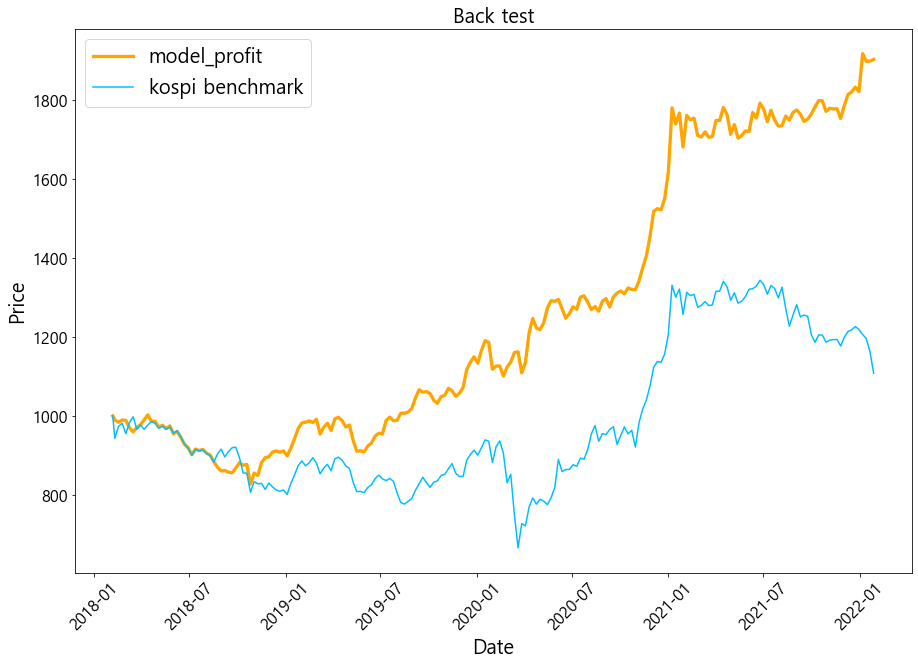

모델 샤프지수:  1.1245142499168717

벤치마크 샤프지수:  0.15426490113760363

모델 주간 수익률 변동성:  13.827862041602387

벤치마크 주간 수익률 변동성:  20.07868909600283

소트리노 지수:  1.821184250219344

벤치마크 소트리노 지수:  0.20704453009437596

모델평균 0.3278774598397402
벤치마크평균 0.08841224977629916


In [226]:
import matplotlib.pyplot as plt
plt.figure(figsize = (15,10))

plt.plot(return_pd.transpose(), linewidth = '3.3', color = 'orange')
plt.plot(return_bench_pd.transpose(), 'deepskyblue')
plt.title("Back test",fontsize=20)
plt.legend(["model_profit", "kospi benchmark"],fontsize=20)
plt.xlabel('Date',fontsize=20)
plt.ylabel('Price',fontsize=20)
plt.xticks(rotation=45,fontsize=16)
plt.yticks(fontsize=16)


plt.show()

return_list1=[ return_list[i]/100 for i in range(len(return_list))]

print("모델 샤프지수: ", (np.mean(return_list) * 52 - 0.015) / (np.array(return_list).std() * np.sqrt(52)))
print("")
print("벤치마크 샤프지수: ", (np.mean(bench_list) * 52 - 0.015) / (np.array(bench_list).std() * np.sqrt(52)))
print("")

print("모델 주간 수익률 변동성: ", np.array(return_list).std() * np.sqrt(52)*100)
print("")
print("벤치마크 주간 수익률 변동성: ", np.array(bench_list).std() * np.sqrt(52)*100)
print("")

minus_return_list=[i for i in return_list if i<0]
minus_bench_list=[i for i in bench_list if i<0]


print("소트리노 지수: ", (np.array(return_list).mean() * 52 - 0.015) / (np.array(minus_return_list).std() * np.sqrt(52)))
print("")
print("벤치마크 소트리노 지수: ", (np.array(bench_list).mean() * 52 - 0.015) / (np.array(minus_bench_list).std() * np.sqrt(52)))
print("")

print("모델평균",np.array(return_list).mean()*100)
print("벤치마크평균",np.array(bench_list).mean()*100)



In [227]:
def dd_plot(data,window):
    
    max_in_window= data.rolling(window,min_periods=1).max()
    dd=(data/max_in_window -1.0) * 100
    mdd=dd.rolling(window,min_periods=1).min()
    return dd , mdd

모델 MDD 및 mean_dd 0   -6.786533
dtype: float64 0   -2.270294
dtype: float64
벤치마크 MDD 및 mean_dd 0   -21.825681
dtype: float64 0   -3.856705
dtype: float64


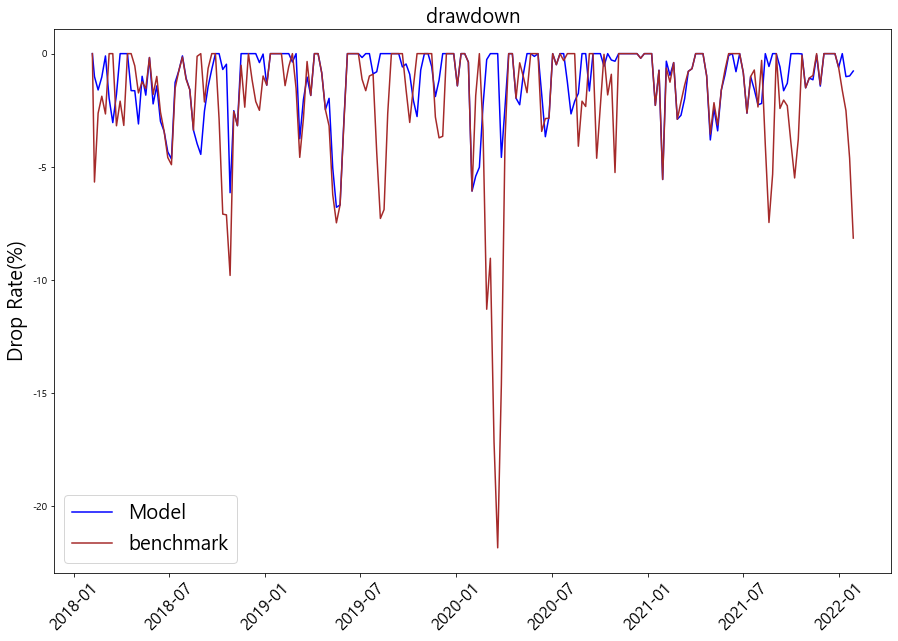

In [228]:
plt.rcParams['axes.unicode_minus'] = False  
dd,mdd=dd_plot(return_pd.T,4)

dd2,mdd2=dd_plot(return_bench_pd.T,4)
print('모델 MDD 및 mean_dd',mdd.min(),np.mean(mdd))
print("벤치마크 MDD 및 mean_dd",mdd2.min(),np.mean(mdd2))
plt.figure(figsize = (15,10))
plt.plot(dd,color="blue",label= "DD")
plt.plot(dd2,color="brown",label= "DD2")
plt.ylabel("Drop Rate(%)",fontsize=20 )
#plt.legend(fontsize=20) # using a size in points
#plt.legend(fontsize="x-large") # using a named size
plt.legend(["Model", "benchmark"],fontsize=20)
plt.title('drawdown',fontsize=20)
plt.xticks(rotation=45,fontsize=16)

#plt.yticks(-1*np.arange(-1, -1*int(mdd2.min()),1))
#plt.legend()
plt.show()

In [229]:
#52주를 이동시켜가며 샤프 retio를 관찰합니다.
see_num=52
SP_ratio_list=[]
for i in range(len(return_list)-see_num):
    SP_ratio=(np.array(return_list[i:i+see_num]).mean() * 52 - 0.015) / (np.array(return_list[i:i+see_num]).std() * np.sqrt(52))
    print(np.array(return_list[i:i+see_num]).std()*np.sqrt(52))
    SP_ratio_list.append(SP_ratio)

0.11636610835693477
0.11596007935517448
0.11583935407289273
0.11576104992902965
0.11602896587934676
0.1204763488166331
0.1212873009621557
0.12112055814052933
0.12235109406480085
0.12530763776202428
0.12477546017142074
0.12398964592129234
0.12506662623753648
0.12427033952638315
0.13028859400665688
0.13316229167828436
0.13294792895310784
0.13151492971729492
0.13239498687071313
0.13176088239111738
0.1317170379338067
0.13149986355073104
0.12996468655554413
0.13348086056539785
0.13353006691221506
0.13394868743094676
0.13344668331295262
0.1341503415268549
0.13256807146139696
0.1312226633469945
0.13057894577097054
0.13250697417445498
0.13313378657499192
0.13337999049684302
0.13303545767609193
0.13280285727337765
0.13384682841960044
0.13426610320631166
0.12024913572634467
0.11663160460352777
0.11679089480959548
0.11237041045504537
0.1130242127286746
0.11309685445080785
0.11316127781438327
0.1197010625390935
0.12004708424907999
0.1202777864277976
0.1203533424154868
0.12144237714662773
0.1208378

In [230]:

SP_ratio_list_bench=[]
sp_col_list=[]
for i in range(len(return_list)-see_num):
    SP_ratio=(np.array(bench_list[i:i+see_num]).mean() * 52 - 0.008) / (np.array(bench_list[i:i+see_num]).std() * np.sqrt(52))
    SP_ratio_list_bench.append(SP_ratio)
    sp_col_list.append(date_list_week[i+see_num])

In [231]:
sp_pd=pd.DataFrame(SP_ratio_list).T
sp_pd_bench=pd.DataFrame(SP_ratio_list_bench).T

sp_pd.columns=sp_col_list
sp_pd_bench.columns=sp_col_list


벤치마크 변동성 0    1.049196
dtype: float64
모델변동성 0    0.783711
dtype: float64


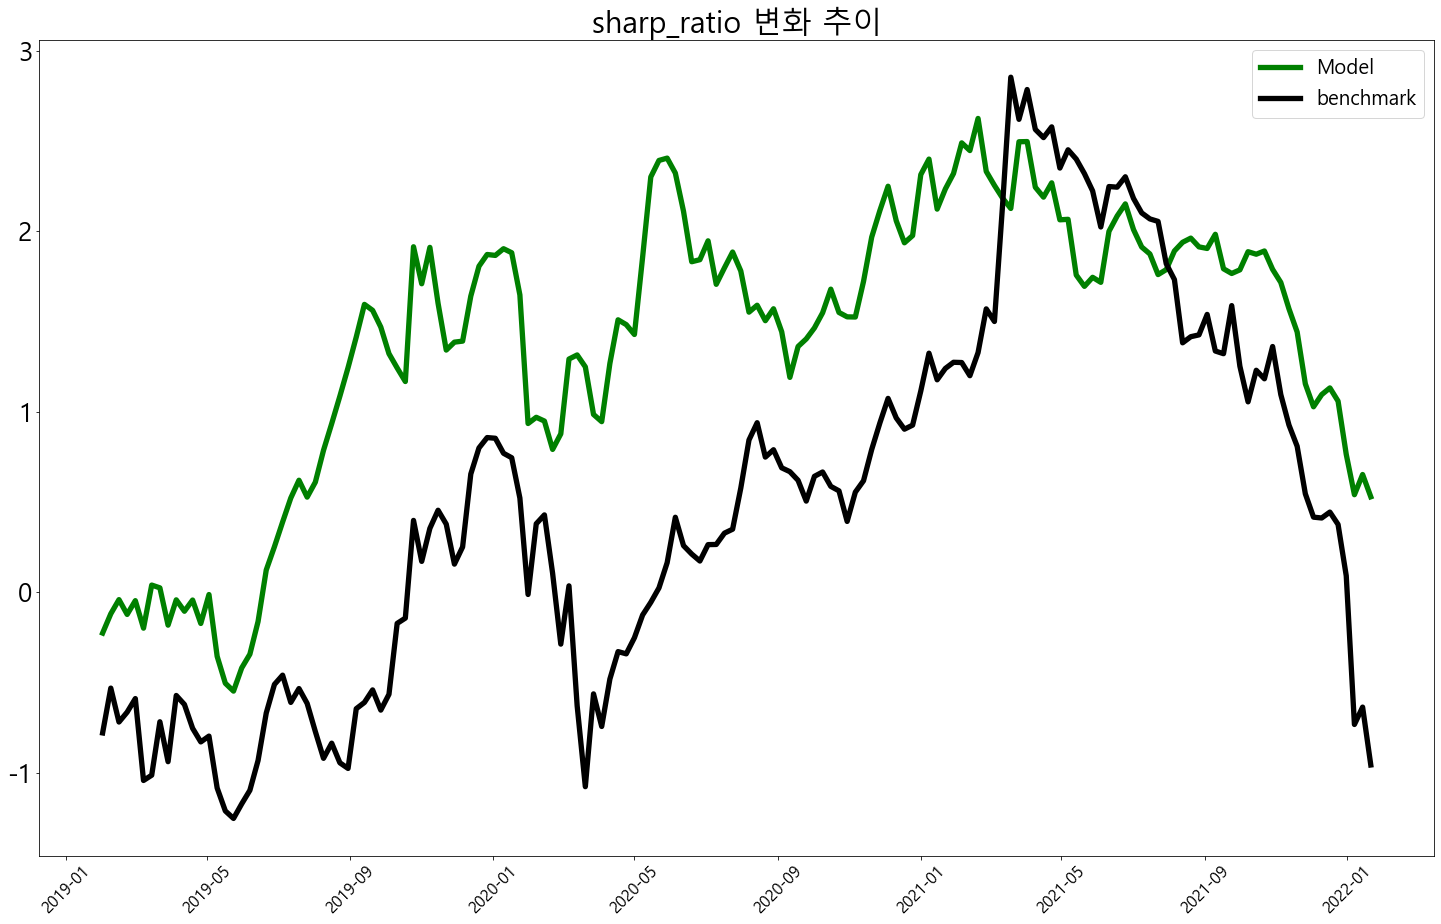

In [232]:

if platform.system() == 'Windows':
    plt.rc('font', family='Malgun Gothic')
elif platform.system() == 'Darwin': # Mac
    plt.rc('font', family='AppleGothic')
else: #linux
    plt.rc('font', family='NanumGothic')

plt.figure(figsize = (25,15))
plt.plot(sp_pd.T,linewidth="5.3",linestyle='solid',color="green")
plt.plot(sp_pd_bench.T,linewidth="5.3",linestyle='solid',color="black")
#plt.plot(mk_return_list,linewidth="5.3",linestyle='dotted',color="blue")
plt.xticks(rotation=45,fontsize=16)
plt.yticks(fontsize=26)
plt.legend(["Model", "benchmark"],fontsize=20)
plt.title("sharp_ratio 변화 추이",fontsize=30)

#plt.rc('xtick', labelsize=0.1)

print("벤치마크 변동성",sp_pd_bench.T.std())
print("모델변동성",sp_pd.T.std())
plt.show()


In [233]:
stockReturn=pd.DataFrame(return_list)

추가적으로 skew값과 kurtosis 데이터를 구해보았습니다.

In [234]:
stockReturn=pd.DataFrame(bench_list)
print(stockReturn.describe())
print('skeness: ', stockReturn.skew(axis=0))
print('kurtosis: ', stockReturn.kurtosis(axis=0))


                0
count  208.000000
mean     0.000884
std      0.027911
min     -0.120158
25%     -0.013834
50%      0.002597
75%      0.016235
max      0.102405
skeness:  0   -0.34579
dtype: float64
kurtosis:  0    3.638992
dtype: float64


In [235]:
def multiply(arr):
    ans = 1
    for n in arr:
        if n == 0:
            return 0
        ans *= n
    return ans


In [236]:
bench_list1=[100*i for i in bench_list]
return_list1=[100*i for i in return_list]

In [237]:
bench_list2=[ multiply(bench_list1[i:i+4])-1 for i in range(0,len(bench_list1)-4,4)]
return_list2=[ multiply(return_list1[i:i+4])-1 for i in range(0,len(bench_list1)-4,4)]

In [238]:
data_linear=pd.DataFrame(return_list,bench_list).reset_index()

In [239]:
data_linear.columns=["x","y"]

In [240]:
fit = ols("y~x",data=data_linear).fit()

In [241]:
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.190
Model:                            OLS   Adj. R-squared:                  0.186
Method:                 Least Squares   F-statistic:                     48.38
Date:                Sun, 27 Feb 2022   Prob (F-statistic):           4.57e-11
Time:                        10:39:44   Log-Likelihood:                 549.25
No. Observations:                 208   AIC:                            -1095.
Df Residuals:                     206   BIC:                            -1088.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0030      0.001      2.505      0.013       0.001       0.005
x              0.3003      0.043      6.956      0.000       0.215       0.385
==============================================================================
Omnibus:                       18.234   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               62.507
Skew:                           0.120   Prob(JB):                     2.67e-14
Kurtosis:                       5.675   Cond. No.                         35.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

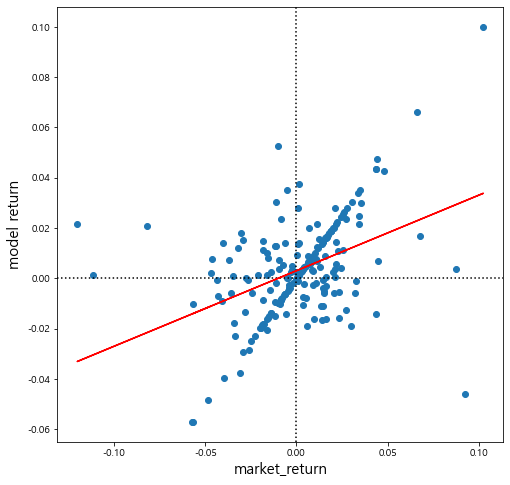

In [242]:
## 시각화
fig = plt.figure(figsize=(8,8))
fig.set_facecolor('white')
 
font_size = 15
plt.scatter(data_linear['x'],data_linear['y']) ## 원 데이터 산포도
plt.axvline(x=0, color = 'black',linestyle=':') # draw x =0 axes 
plt.axhline(y=0, color = 'black',linestyle=':') # draw y =0 axes


plt.plot(data_linear['x'],fit.fittedvalues,color='red') ## 회귀직선 추가
 
plt.xlabel('market_return', fontsize=font_size)

plt.ylabel('model return',fontsize=font_size)
plt.show()

In [243]:
high_regime=high_value.columns+datetime.timedelta(days=4)
low_regime=low_value.columns+datetime.timedelta(days=4)

In [244]:
last_market_list=[]
for i in return_bench_pd:
    if i in high_regime :#or i in ac :
        print('상승국면')
        last_market_list.append(1)
    else:
        last_market_list.append(0)
        

last_market_list2=[]
for i in return_bench_pd:
    if i in low_regime :#or i in ac :
        print('하락국면')
        last_market_list2.append(1)
    else:
        last_market_list2.append(0)

상승국면
상승국면
상승국면
상승국면
상승국면
상승국면
상승국면
상승국면
상승국면
상승국면
상승국면
상승국면
상승국면
상승국면
상승국면
상승국면
하락국면
하락국면
하락국면
하락국면
하락국면
하락국면
하락국면
하락국면


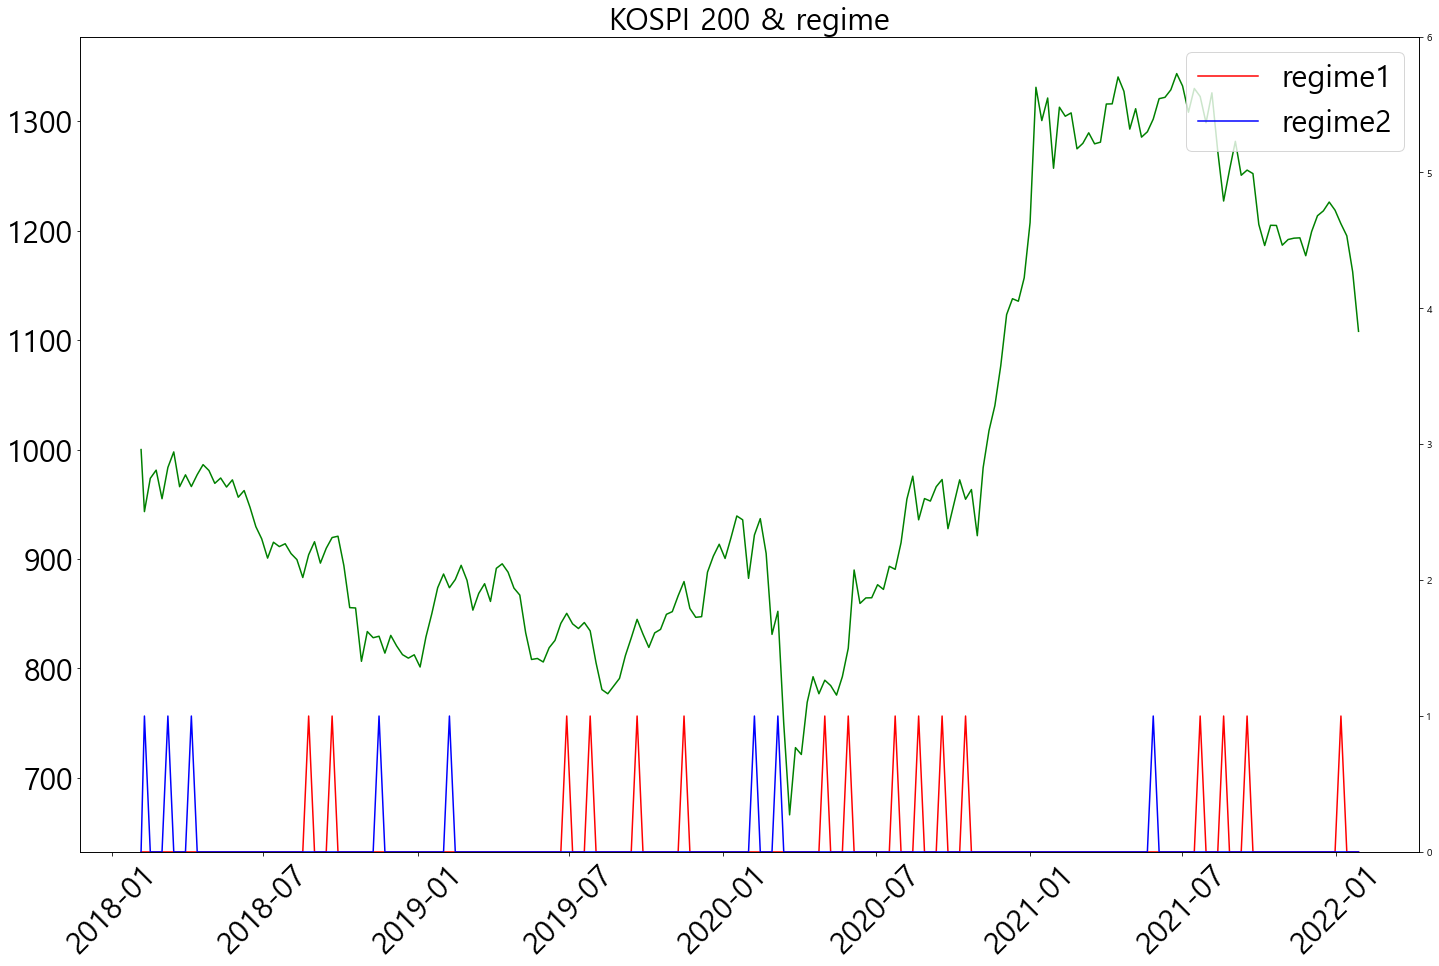

In [245]:

plt.rcParams["figure.figsize"] = (24, 15)
fig, ax1 = plt.subplots()
ax1.plot(return_bench_pd.columns, return_bench_pd.values[0], color='green')
plt.xticks(rotation=45,fontsize=30)
plt.yticks(fontsize=30)
ax2 = ax1.twinx()
ax2.plot(return_bench_pd.columns, last_market_list, color='red')
ax2.plot(return_bench_pd.columns, last_market_list2, color='blue')
plt.ylim([0,6])
plt.legend(('regime1','regime2'),fontsize=30)
plt.title("KOSPI 200 & regime",fontsize=30)

#plt.yticks(fontsize=30)

plt.show()